# DM - Mobility Task

Team members:
 * Frick Bernhard (a01505541@unet.univie.ac.at)
 * Postlmayr Billie Rosalie (a01307120@unet.univie.ac.at)

Former team members that opted out of the course:
 * Decsi István (a11834026@unet.univie.ac.at)
 * Krivanek Yvonne-Nadine (a01404589@unet.univie.ac.at)

Tokens:
 * Frick: dm19_byrzma (id: 35)
 * Postlmayr: dm19_postlmayr (id: 32)

In [1]:
%matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import mplleaflet
import re
import dateutil.parser
from matplotlib.dates import date2num
from IPython.display import display, HTML

In [3]:
data_dir = "data"

In [4]:
all_files = os.listdir(data_dir)

In [5]:
# remove non-trip files and non-whitelisted files

whitelist_ids = [5, 46, 74, 127, 128, 129, 131, 165, 99, 105, 107, 108, 109, 152, 202, 203, 13, 28, 43, 52, 145, 146, 22, 24, 26, 42, 102, 103, 147, 214, 215, 19, 134, 137, 139, 142, 220, 222, 223, 224, 26, 248, 246, 245, 241, 84, 93, 235, 236, 33, 36, 37, 40, 49, 120, 113, 114, 115, 116, 117, 218, 219, 226, 227, 240, 21, 32, 38, 70, 95, 199, 78, 82, 83, 160, 161, 208, 209, 55, 9, 35, 88, 210, 211, 217, 72, 47, 201, 204, 91]

def filter_trips(trip):
    # skip files that are not a trip
    if re.search("^\d+_\d+_\d{4}-\d{2}-\d{2}T\d{6}\.\d{3}$", trip) is None:
        return False

    # extract the trip id
    trip_id = trip.split('_')[1]

    # keep trips that are whitelisted
    if (int(trip_id) in whitelist_ids):
        return True

    # otherwise: skip the trip
    return False

whitelisted_trips = list(filter(filter_trips, all_files))

In [6]:
# dict: trip-id -> folder name
all_trips = dict(map(lambda trip: (int(trip.split('_')[1]), trip), whitelisted_trips))

## 1. Our Trips

In [7]:
def trip_overview(trips):
    print("Number of trips: ", len(trips))

    for tid, trip in trips.items():

        display(HTML(f"<h1>Trip id {tid}</h1>".format(tid)))

        # read markers file
        marker_col_names = ["time", "key", "value", "mode", "longitude", "latitude", "col7", "col8", "col9"]
        markers = pd.read_csv(os.path.join("data", trip, "markers.csv"), sep=';', names=marker_col_names, skiprows=1)

        # total duration
        start = dateutil.parser.parse(markers.loc[markers.index[0], 'time'])
        stop = dateutil.parser.parse(markers.loc[markers.index[-1], 'time'])
        print("Duration:", stop-start)

        # print markers table
        mode_changes = markers[markers["key"] == "CGT_MODE_CHANGED"]
        display(HTML(mode_changes.to_html()))

        # prepare acceleration data for plot
        acceleration = pd.read_csv(os.path.join("data", trip, "acceleration.csv"))
        acceleration['time'] = date2num(pd.to_datetime(acceleration['time']))
        acceleration['acc_norm'] = np.linalg.norm(acceleration[['x', 'y', 'z']].values, axis=1)
        acceleration = acceleration.drop(['x', 'y', 'z'], axis=1)

        # plot acceleration data
        plt.figure(figsize=(20,10))
        plt.grid(True)
        plt.plot_date(acceleration['time'], acceleration['acc_norm'], linewidth=1, color='black', linestyle='solid', marker='None')

        max_acc = np.max(acceleration['acc_norm'])

        # markers for acceleration data
        for index, row in mode_changes.iterrows():
            x = date2num(pd.to_datetime(row["time"]))
            # vertical line
            plt.axvline(x=x)
            # mode text
            plt.text(x=x, y=max_acc*.95, s=row["mode"], rotation=90, fontsize=16)
        plt.show()

        # plot map with location data
        positions = pd.read_csv(os.path.join("data", trip, "positions.csv"))
        positions = positions[positions["location_source"] == 1]
        positions = positions.filter(items=['longitude', 'latitude'])
        plt.figure(figsize=(20,8))
        plt.plot(positions['longitude'], positions['latitude'], 'r.', markersize=4)
        display(mplleaflet.display())

        # only process one trip
        break;

### Bernhard Frick

In [8]:
frick_trip_ids = {113, 114, 115, 116, 117, 218, 219, 226, 227, 240}

In [9]:
frick_trips = dict(filter(lambda elem: elem[0] in frick_trip_ids, all_trips.items()))

Number of trips:  9


Duration: 0:04:27.430000


,time,key,value,mode,longitude,latitude,col7,col8,col9
4,2019-12-15T16:33:50.359Z,CGT_MODE_CHANGED,2019-12-15T16:33:41Z,WALK,16.33780542,48.20154978,-,Urban-Loritz-Platz,470227831.0
5,2019-12-15T16:38:09.031Z,CGT_MODE_CHANGED,2019-12-15T16:38:07Z,WALK,16.34142774,48.20284915,-,NaN,NaN


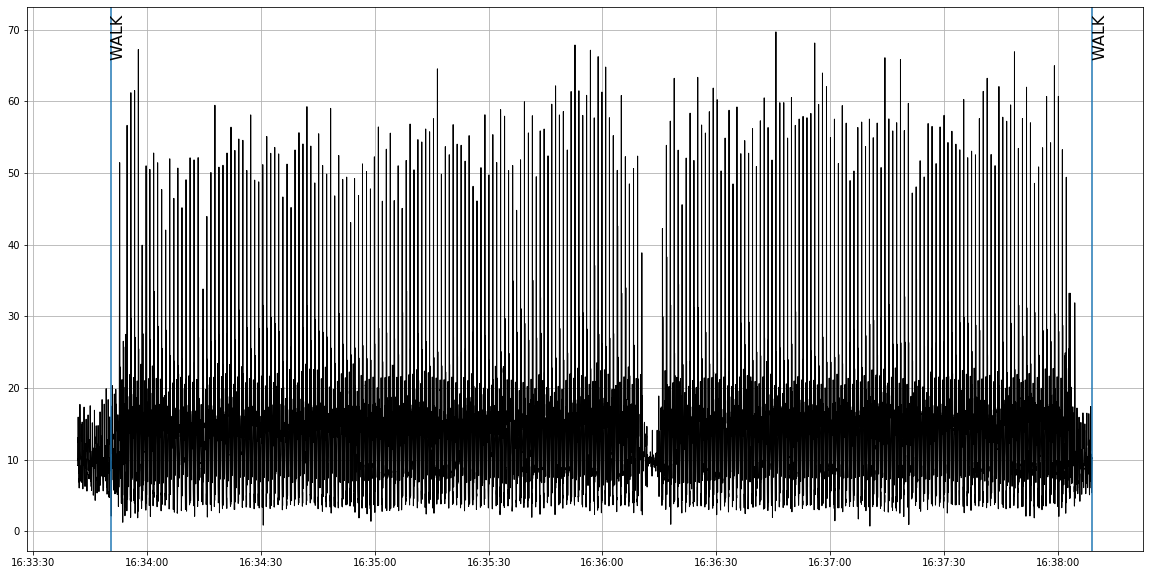

In [11]:
trip_overview(frick_trips)

### Billie Rosalie Postlmayr

In [12]:
postlmayr_trip_ids = {84, 93, 235, 236}

In [13]:
postlmayr_trips = dict(filter(lambda elem: elem[0] in postlmayr_trip_ids, all_trips.items()))

Number of trips:  4


Duration: 0:10:39.424000


,time,key,value,mode,longitude,latitude,col7,col8,col9
4,2019-12-15T10:41:46.758Z,CGT_MODE_CHANGED,2019-12-15T10:41:37Z,WALK,16.3417394,48.2166381,-,NaN,NaN
5,2019-12-15T10:47:04.963Z,CGT_MODE_CHANGED,2019-12-15T10:46:56Z,TRAM,16.342368075709786,48.21710115837203,-,Alser Straße,3.630096e+09
6,2019-12-15T10:52:16.875Z,CGT_MODE_CHANGED,2019-12-15T10:52:15Z,TRAM,16.327132627745957,48.219028865563665,-,Rosensteingasse,7.465417e+06


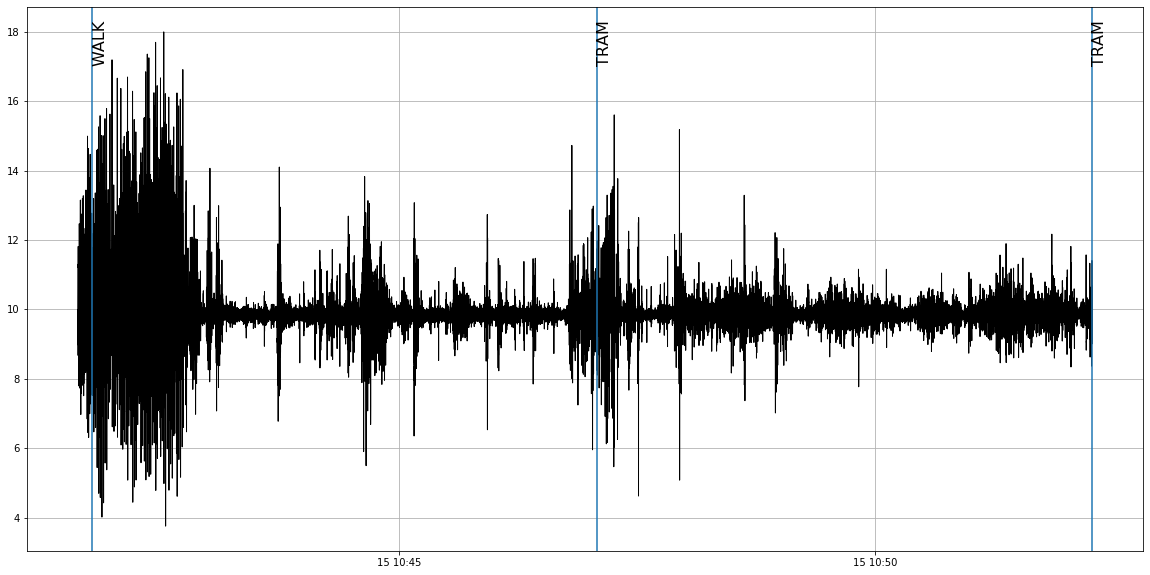

In [14]:
trip_overview(postlmayr_trips)

## 2. Data Preprocessing

Not all trips were of sufficient quality to be used as a basis.
This sheet lists all trips that are to be used.

https://docs.google.com/spreadsheets/d/11Ta24L86uB1UiKwSa5of5MKfUIaoXxq53kGWQ8U-AyI/edit#gid=0

Preprocessing is done in `DataSectioner.py`.

This script consumes the whitelisted input data and produces a single `export.csv` file that contains all acceleration data, downsampled, normed, etc.

`export.csv` is then in turn used by the next script to train the model.

## 3. Visualization


The data set consists of 94 (mostly) multimodal trips by 17 students.

The share of each transport mode is as follows:
 * Walk: hh:mm
 * Bicycle:
 * Car:
 * Bus:
 * Tram:
 * Metro:
 * Train: hh:mm

In total, there are hh:mm hours of recorded travel time.

We visualized 5 trips as an example.





Find your own way to visualize your trips to fully understand it and explain why you chose these kind of plots (probably you will need more than one type of plot).

Mandatory: You should be able to plot the accelerometer sensor data of a selected trip (x, y, z, total).

Optionally:
 * Plotting time series of moving statistics with sliding windows (e.g. moving average).
 * Plot the GPS data of your trips on a map, to actually see where the recorded trip took place.
 * Plot sensor data of different sensors (in this case do not forget the preprocessing steps).

Start with basic statistics of your data (mean, median, variance, quantiles, ACF AutoCorrelation Function, etc.) to get a deeper understanding of your data and of characteristics of different transport modes.



## 4. Classification

results and a detailed description, including code, how you got to the results


Language of our choice. Python.

DM-Technique of our choice. Clustering? ML/NN? etc.

1. Split each trip into segments of 10 seconds (after preprocessing steps this should be a 1-dimensional time series of 10 * 10 = 100 observations). Skip segments that are
a. shorter than 10 seconds (typically the last segment of a trip), or
b. bimodal (segments covering two transport modes, at the change of the transport mode)


---


The whole task, and all subtasks concentrate only on the accelerometer sensor data. Performing Subtasks 1-6 for accelerometer is mandatory. It is optional to use GPS or any other sensor data (if available) to enrich the data set. Most likely this would improve your methods performance, if you add sensor data (especially GPS), however it’s optional.
